# Modelling Hidden Confounders in Causal Inference: An Empirical Study with CEVAE

We are in the context of an **observational study**: we observe outcomes ($Y$) for available subjects (with many characteristics $X_i$) on the variables of interest ($T$) without control over this variable. This setting poses a problem: there may be lurking variables not taken into account who affect both the treatment and the outcome (i.e., confounders) making the establishment of cause and effect much harder.

This stands in contrast to Randomized Clinical Trials (RCTs), where instead we can randomize the assignment of the subjects to the values of the variable of interest so that no confounders are present.

**Causal Graphical Model (Causal Bayesian Network)**

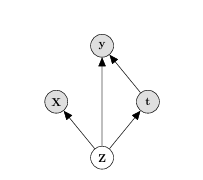

We **observe** the features $X_i$, the treatment $T$ and the outcome $Y$, but we do **not observe** the hidden confounder $Z$!

Our **objective** is to estimate the **Average Treatment Effect** (ATE), i.e., the effect of $T$ on $Y$.

All the evaluations are based on two metrics based on the Individual Treatment Effect (ITE), typical metric in causal inference problems, defined as:

...

RMSE of the ITE:

...

and the ATE error:

...

In [2]:
from data_gen import synthetic_dataset_non_linear, synthetic_dataset_linear
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pyro
from pyro.contrib.cevae import CEVAE
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import logging
import itertools


logging.getLogger("pyro").setLevel(logging.DEBUG)
logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)

In [13]:
data = synthetic_dataset_linear(n=1000, beta=2.0, num_proxies=10, seed=0)
data.keys()
length_x = len(data["x"][1]) 

#clone
data_original = data.copy()

In [5]:
# translating the dictionary in a dataframe
# I need to change the x matrix in different x columns
for i in range(data["x"].shape[1]):
    data["x_"+str(i)] = data["x"][:,i]

data.pop("x",None)

data_df = pd.DataFrame.from_dict(data)
data_df.head()

,t,y,z,ite,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,0.0,-2.208010,-1.125840,0.437080,-1.731487,-1.221312,1.362937,-1.761153,1.143016,1.214882,1.167682,0.343493,0.194201,0.303988
1,0.0,-0.875835,-1.152360,0.423820,-0.456844,1.407218,1.781436,-1.574662,0.310614,0.521926,-0.086948,-0.668354,0.761953,2.022159
2,0.0,-4.025739,-0.250579,0.874711,1.478320,-1.480874,0.375845,-0.744108,0.327447,0.911712,-1.282674,-1.145216,0.744192,0.787970
3,1.0,0.659674,-0.433879,0.783061,-0.632539,-1.681831,-1.748725,0.701550,-0.586185,1.948595,-0.788646,-2.934193,0.032010,0.836807
4,0.0,1.993935,0.848710,1.424355,1.707293,0.087381,-1.271084,-1.395154,-0.485180,0.207355,-1.430470,1.030292,-1.312681,-1.048788


We can obtain a naive estimate for the ATE by taking the mean of the outcome in the two groups in the dataset (those that received the treatment and those who didn't). We call this estimate "unadgusted" because we are not considering any of the covariates that can affect the treatment effect.

In [6]:
data_1 = data_df[data_df["t"]==1.0]
data_0 = data_df[data_df["t"]==0.0]

print("Unadjusted ATE", np.mean(data_1["y"])- np.mean(data_0["y"]))

Unadjusted ATE 2.6313312


## First strategy: assuming "No hidden confounders"

Assuming that there are no hidden confounders (also called **unconfoundness**) means that we consider the $X_i$ to be the only confounders and thus we consider them to be measured!

In this case the set of variables $X_i$ satisfy the back-door criterion and we can apply classical methods for causal inference.

In [7]:
# model = CausalModel(data_df, treatment="t", outcome="y", common_causes="z")
# this would be the real model since we know how the data was generated
# however, in a real setting, we don't usually have access to the real confounders and we consider the proxies variables we have for it instead  

model = CausalModel(data_df, treatment="t", outcome="y", common_causes=["x_"+str(i) for  i in range(0,10)])

In [ ]:
# this doesn't work in all python enviroments, for reference look at the generated image
#model.view_model(file_name="causal_model_no_hidden_confounder")

We identify the **estimand** using the back-door criterion. Again, we remark the need for the unconfoundedness assumption.

The estimand type is **non parametric** because we are **not** assuming any parametric model for the treatment effect.

The other two types of estimand (instrumental variable and front-door criterion) are **not** available because there are no instrumental variables or mediators in the causal graph. 


In [ ]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

We want to compute how the value of $y$ will change with respect to $T$, controlling for all $X_i$.

For this purpose, we estimate the ATE using the linear regression to approximate the conditional probability $p(y|x,t)$.

In [ ]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)


We can also explicitely compute the linear regression using scikit-learn: we verify that the result is the same!

In [29]:
import torch
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class LinearModel:
    def __init__(self, **kwargs):
        self.model = LinearRegression(**kwargs)

    def fit(self, x, t, y, **fit_kwargs):
        # Convert to numpy if input is torch.Tensor
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        if isinstance(t, torch.Tensor):
            t = t.detach().cpu().numpy()
        if isinstance(y, torch.Tensor):
            y = y.detach().cpu().numpy()

        X = np.concatenate([t[:, None], x], axis=1)
        self.model.fit(X, y, **fit_kwargs)
        y_pred = self.model.predict(X)
        mse = mean_squared_error(y, y_pred)
        return [mse]  # Fake ELBO for compatibility

    def ite(self, x):
        if isinstance(x, torch.Tensor):
            x_np = x.detach().cpu().numpy()
        else:
            x_np = x

        X1 = np.concatenate([np.ones((x_np.shape[0], 1)), x_np], axis=1)
        X0 = np.concatenate([np.zeros((x_np.shape[0], 1)), x_np], axis=1)
        y1 = self.model.predict(X1)
        y0 = self.model.predict(X0)
        diff = y1 - y0
        return torch.tensor(diff, dtype=torch.float32).reshape(-1, 1)


In [ ]:
feature_cols = [f'x_{i}' for i in range(10)]
x = data_df[feature_cols]   
t = np.asarray(data_df['t'])
y = data_df['y']

linear_model = LinearModel()
linear_model.fit(x, t, y)          

ite = linear_model.ite(x)         
ate = ite.mean().item()
print("Average Treatment Effect (ATE):", ate)


We estimated that receiving the treatment (t=1) increases the outcome of $1.826$ units after adjusting for covariates. This estimates has a very small p-value, suggesting that this effect is statistically significant.

Other types of estimation are possible, we try a couple more.

In [ ]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching", test_significance=True
)

print(estimate)

In [ ]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting", test_significance=True
)

print(estimate)

With different estimation methods we have obtained the following results:
- $1.82$ with linear regression
- $1.66$  with propensity score matching
- $1.72$ with propensity score weighting

**Remark**: I also verified that, if I give to the model the real hidden confounder (Z), it correctly predicts a causal effect close to 1 for all estimation methods!

## Second strategy: keeping into account the latent variable

If we think that there must be an hidden confounder that we have to account for, we can use the Causal Effect Variational AutoEncoder (CEVAE) to try to estimate it based on the available data.


## PGM

Assume a simple graphical model, as the one defined by the problem. We assume the following general relationship

$$
Z\sim \mathcal{N}(0,1)\\
X\sim \mathcal{N}(az+b,\Sigma_X)\\
T|Z\sim \text{Bernoulli}(\sigma(cz))\\
Y|Z,T\sim\mathcal{N}(et+fz,\sigma_Y)
$$

we want to find all these parameters usign variational inference

In [9]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, autoguide
from pyro.optim import Adam

class PyroLinearProxyModel:
    def __init__(self, init_scale=0.1, learning_rate=1e-2, weight_decay=0.0):
        """
        A simple 1-dim latent SVI model whose estimated ATE is the learned scalar 'e'.
        """
        self.init_scale     = init_scale
        self.learning_rate  = learning_rate
        self.weight_decay   = weight_decay

    def model(self, x, t, y):
        N, D = x.shape
        a      = pyro.param("a",      torch.zeros(D))
        b      = pyro.param("b",      torch.zeros(D))
        c      = pyro.param("c",      torch.tensor(0.))
        e      = pyro.param("e",      torch.tensor(0.))   # <-- ATE
        f      = pyro.param("f",      torch.tensor(0.))
        sigmax = pyro.param("sigmax", torch.ones(D))
        sigmay = pyro.param("sigmay", torch.tensor(1.))

        with pyro.plate("data", N):
            z = pyro.sample("z", dist.Normal(0., 1.))
            loc_x = a * z.unsqueeze(-1) + b
            pyro.sample("x_obs", dist.Normal(loc_x, sigmax).to_event(1), obs=x)
            pyro.sample("t_obs", dist.Bernoulli(logits=c * z),        obs=t)
            pyro.sample("y_obs", dist.Normal(e * t + f * z, sigmay),  obs=y)

    def fit(self,
            x, t, y,
            num_epochs: int = 100,
            batch_size: int = 100,       # ignored here, we do full-batch
            learning_rate: float = None,
            weight_decay: float    = None,
            log_every: int        = 0
           ):
        """
        Runs SVI on (x, t, y), returns a list of ELBO losses.
        """
        # override defaults if provided
        lr = learning_rate or self.learning_rate
        wd = weight_decay  or self.weight_decay

        pyro.clear_param_store()
        guide = autoguide.AutoDiagonalNormal(self.model, init_scale=self.init_scale)
        optim = Adam({"lr": lr, "weight_decay": wd})
        svi   = SVI(self.model, guide, optim, loss=Trace_ELBO())

        losses = []
        for epoch in range(1, num_epochs+1):
            loss = svi.step(x, t, y)
            losses.append(loss)
            if log_every and epoch % log_every == 0:
                print(f"[SVI] epoch {epoch:>4} ELBO = {loss:.2f}")

        # snapshot & freeze
        raw = {name: val.detach().clone()
               for name, val in pyro.get_param_store().items()}
        pyro.clear_param_store()
        for name, val in raw.items():
            p = pyro.param(name, val)
            p.requires_grad_(False)

        return losses

    def ite(self, x):
        """
        Returns per-unit ITE estimates.  In this linear model
        the treatment effect is constant = e.
        """
        N = x.shape[0]
        e = pyro.param("e")
        return e * torch.ones(N, dtype=x.dtype, device=x.device)

    def estimate_ate(self, x=None, t=None, y=None):
        """
        The ATE is exactly the learned 'e' scalar.
        """
        return pyro.param("e").item()


In [18]:
pgm = PyroLinearProxyModel(init_scale=0.1, learning_rate=5e-3, weight_decay=0.0)

x, t, y   = (
    data_original["x"],
    data_original["t"],
    data_original["y"]
    )

pgm.fit(x, t, y, num_epochs=1000, log_every=100)          

ite = pgm.ite(x)         
ate = ite.mean().item()
print("Average Treatment Effect (ATE):", ate)

[SVI] epoch  100 ELBO = 100711.49
[SVI] epoch  200 ELBO = 64061.11
[SVI] epoch  300 ELBO = 44660.91
[SVI] epoch  400 ELBO = 34426.83
[SVI] epoch  500 ELBO = 28837.62
[SVI] epoch  600 ELBO = 25838.71
[SVI] epoch  700 ELBO = 24054.72
[SVI] epoch  800 ELBO = 23035.93
[SVI] epoch  900 ELBO = 22339.32
[SVI] epoch 1000 ELBO = 21879.13
Average Treatment Effect (ATE): 1.036778450012207


## CEVAE

In [ ]:
# # optimal hyperparameters till now
# cevae = CEVAE(
#     feature_dim=length_x,
#     latent_dim=1,
#     outcome_dist="normal",
#     num_layers=5,
#     hidden_dim=300
#     )

# losses = cevae.fit(
        # x, t, y,
        # num_epochs=100,
        # batch_size=100,
        # learning_rate=5e-4,
        # learning_rate_decay=0.1,
        # weight_decay=1e-6
        # )

In [ ]:
x, t, y   = (
    data_original["x"],
    data_original["t"],
    data_original["y"]
    )

z = data_original["z"]

length_x  = x.shape[1]

# ----------------------------- train-test split ----------------------------- #

x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(
    x, t, y, test_size=0.2, random_state=0
)

In [ ]:
# before every training run
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

losses = cevae.fit(
    x_train, t_train, y_train,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    # learning_rate_decay=0.1,
    # weight_decay=1e-6
    )

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

In [ ]:
# Save the model
torch.save(cevae, "cevae_model_full.pth")

cevae_loaded = torch.load("cevae_model_full.pth", weights_only=False)

## Experiments

### Plot also the test loss

In [20]:
import torch, types
from torch.utils.data import DataLoader, TensorDataset
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.optim import ClippedAdam
from pyro.contrib.cevae import PreWhitener, TraceCausalEffect_ELBO

def train_cevae(
    model,                      # a CEVAE instance
    x, t, y,                    # training data
    x_val=None, t_val=None, y_val=None,   # optional validation data
    num_epochs=100, batch_size=100,
    lr=1e-3, lr_decay=0.1, weight_decay=1e-4,
    log_every=10,
):
    model.whiten = PreWhitener(x)           # <-- same pre-whiten stats
    train_loader = DataLoader(TensorDataset(x, t, y),
                              batch_size=batch_size, shuffle=True,
                              generator=torch.Generator(device=x.device))
    num_steps = num_epochs * len(train_loader)
    optim = ClippedAdam({"lr": lr,
                         "weight_decay": weight_decay,
                         "lrd": lr_decay ** (1/num_steps)})
    svi = SVI(model.model, model.guide, optim, TraceCausalEffect_ELBO())
    tr_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # ---- training pass
        epoch_loss = 0.0
        for xb, tb, yb in train_loader:
            xb = model.whiten(xb)
            batch_loss = svi.step(xb, tb, yb, size=len(x))
            batch_loss = batch_loss / len(x)
            epoch_loss += batch_loss

        tr_losses.append(epoch_loss / len(train_loader))

        # ---- validation pass (optional)
        if x_val is not None:
            with torch.no_grad():
                xv = model.whiten(x_val)
                vloss = svi.evaluate_loss(xv, t_val, y_val,
                                          size=len(x_val)) / len(x_val)
            val_losses.append(vloss)

        if log_every and (epoch+1) % log_every == 0:
            msg = f"[{epoch+1:03d}] train={tr_losses[-1]:.4f}"
            if x_val is not None:
                msg += f" | val={val_losses[-1]:.4f}"
            print(msg)

    return (tr_losses, val_losses) if x_val is not None else tr_losses


In [21]:
# before every training run
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

train_losses, val_losses = train_cevae(
    cevae,
    x_train, t_train, y_train,
    x_val=x_test, t_val=t_test, y_val=y_test,
    num_epochs=100,
    batch_size=100,
    lr=5e-3,
    # learning_rate_decay=0.1,
    # weight_decay=1e-6
    )


NameError: name 'x_train' is not defined

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training and Validation Loss')
plt.legend()
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

### General function for the experiments

In [22]:
def run_experiment(
    param_grid: dict,
    data_fn: callable,
    model_cls: type,
    metrics_fns: dict,
    data_kwargs: dict,
    model_kwargs: dict,
    fit_kwargs: dict,
    test_size: float = 0.2,
    random_state: int = 0,
):
    """
    Sweeps over one or more parameters (given in param_grid) and returns a DataFrame
    of results.

    param_grid: mapping from "stage__param_name" to list of values.
       e.g. {"data__shuffle_pct": np.linspace(0,1,11),
              "model__latent_dim": [1,2,5]}

    data_fn:        function(**data_kwargs) -> dict with keys "x","t","y","ite"
    
    model_cls:      class of your model; instantiated as model_cls(**model_kwargs)
    
    fit_kwargs:     kwargs passed to model.fit(...)
    
    metrics_fns:    mapping from metric_name -> function(model, x_te, ite_te) -> float

    Returns a pandas DataFrame with one row per combination, columns for each
    swept param plus each metric.
    """
    # 1) build list of all combinations
    keys, values = zip(*param_grid.items())
    combos = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

    records = []
    for combo in combos:
        # prepare stage-specific kwargs
        dk = data_kwargs.copy()
        mk = model_kwargs.copy()
        fk = fit_kwargs.copy()

        # dispatch combo entries into dk/mk/fk
        for full_key, val in combo.items():
            stage, param = full_key.split("__", 1)
            if stage == "data":
                dk[param] = val
            elif stage == "model":
                mk[param] = val
            elif stage == "fit":
                fk[param] = val
            else:
                raise ValueError(f"Unknown stage “{stage}”")

        # run one trial
        data = data_fn(**dk)
        x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
        x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
            x, t, y, ite, test_size=test_size, random_state=random_state
        )

        pyro.clear_param_store()
        model = model_cls(**mk)
        losses = model.fit(x_tr, t_tr, y_tr, **fk)

        # 4) build result row
        row = dict(combo)
        row["final_elbo"] = losses[-1] 
        for mname, mfn in metrics_fns.items():
            row[mname] = mfn(model, x_te, ite_te)
        records.append(row)

    return pd.DataFrame.from_records(records)

# ---------------------------- metrics definition ---------------------------- #

def abs_ate_error(model, x_te, ite_te):
    est = model.ite(x_te).mean().item()
    true = ite_te.mean().item()
    return abs(est - true)

def rel_ate_error(model, x_te, ite_te):
    est = model.ite(x_te).mean().item()
    true = ite_te.mean().item()
    return abs(est - true) / abs(true)

def nrmse_ite(model, x_te, ite_te):
    pred = model.ite(x_te).cpu().numpy()
    true = ite_te.cpu().numpy()
    rmse = np.sqrt(np.mean((pred - true) ** 2))
    return rmse / true.std()


In [23]:
def plot_experiment_results(results, x_param="data__shuffle_pct"):
    """
    Given a DataFrame `results` where one column is your swept parameter
    (e.g. "data__shuffle_pct") and the others are metrics, this function
    will produce one plot per metric.
    """
    # find all metric columns
    metrics = [c for c in results.columns if c != x_param]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(results[x_param], results[metric], marker="o")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.tight_layout()
        plt.show()

In [24]:
def plot_two_experiment_results(results, linear_results, x_param="data__shuffle_pct"):
    """
    Plot results and linear_results overlapping for each metric on the same plot.
    Assumes both DataFrames have the same x_param values and metric columns.
    """
    # find all metric columns
    metrics = [c for c in results.columns if c != x_param and c!= "final_elbo"]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(results[x_param], results[metric], marker="o", label="Results")
        plt.plot(linear_results[x_param], linear_results[metric], marker="x", label="Linear Results")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [25]:
def plot_three_experiment_results(results, linear_results, pgm_results, x_param="data__shuffle_pct"):
    """
    Plot results and linear_results overlapping for each metric on the same plot.
    Assumes both DataFrames have the same x_param values and metric columns.
    """
    # find all metric columns
    metrics = [c for c in results.columns if c != x_param and c!= "final_elbo"]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(results[x_param], results[metric], marker="o", label="Results")
        plt.plot(linear_results[x_param], linear_results[metric], marker="x", label="Linear Results")
        plt.plot(pgm_results[x_param], pgm_results[metric], marker="^", label="PGM Results")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [26]:
num_proxies = 10

data_defaults_non_lin = dict(
    n=1000,
    num_proxies=num_proxies,
    sigma_x=1.0,
    sigma_y=1.0,
    prior_type="gaussian",
    seed=0,
)

data_defaults_linear = dict(
    n=1000,
    beta=1.0,
    num_proxies=num_proxies,
    shuffle_pct=0.0,
    sigma_x=1.0,
    sigma_y=1.0,
    seed=0,
)
model_defaults = dict(
    feature_dim=num_proxies,
    latent_dim=1,
    num_layers=3,   # number of hidden layers
    hidden_dim=20,  # number of hidden units in each layer
    outcome_dist="normal",
)

fit_defaults = dict(
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=0,
)

metrics = {
    "rel_ate_err": rel_ate_error,
    "nrmse_ite": nrmse_ite,
}

### E1: increasing sample size

In [32]:
# set up params to sweep
param_grid = {
    "data__n": np.linspace(100,1000,10, dtype=int),
}

n_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_non_linear,  
    model_cls    = PyroLinearProxyModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)

# run the experiment
results = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

# solving the problem with LINEAR REGRESSION
linear_results = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_non_linear,  
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)

INFO 	 Training with 1 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.02491
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.03042
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.7733
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78987
INFO 	 Training with 3 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.80565
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.80982
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.3312
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.34768
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.66418
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.6519
INFO 	 Training with 5 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.24233
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.22641
INFO 	 Traini

   data__n  final_elbo  rel_ate_err  nrmse_ite
0      100   18.095159     1.246305   3.070462
1      200   17.713564     0.828501   1.845399
2      300   18.618760     0.739182   1.645436
3      400   16.776870     0.344985   0.950952
4      500   18.228302     0.690358   1.499406
5      600   17.909242     0.205936   0.676261
6      700   18.027735     0.389508   1.129375
7      800   18.105241     0.500918   1.136570
8      900   18.087364     0.235042   0.697997
9     1000   18.188556     0.321387   0.873720
   data__n  final_elbo  rel_ate_err  nrmse_ite
0      100    1.507097     0.504211   1.546478
1      200    1.363580     0.701620   1.709741
2      300    1.601729     0.810609   1.903010
3      400    1.192751     0.565327   1.460666
4      500    1.710758     0.767079   1.803890
5      600    1.409633     0.456945   1.330246
6      700    1.673513     0.648593   1.573452
7      800    1.587039     0.788339   1.790635
8      900    1.309255     0.522562   1.362811
9     1000   

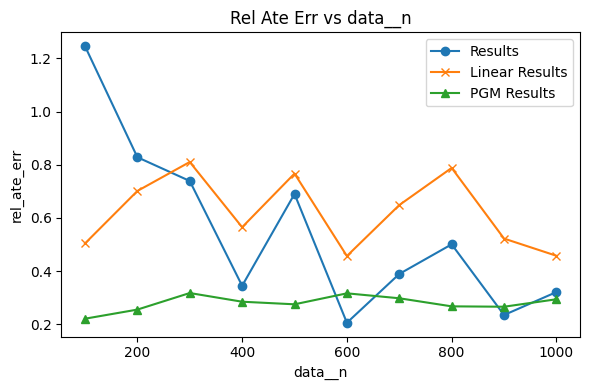

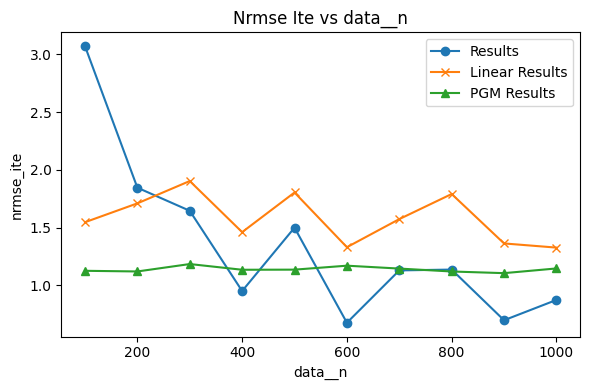

In [33]:
print(results)
print(linear_results)
print(n_pgm)
plot_three_experiment_results(results, linear_results, n_pgm, x_param="data__n")

#### Same Experiment but with linear data

### E2: increasing correlation among proxies (not through $Z$)

In [ ]:
# set up params to sweep
param_grid = {
    "data__rho": np.linspace(0.0, 0.9, 10),
}

corr_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_non_linear,  
    model_cls    = PyroLinearProxyModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)

# run the experiment
corr = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)


INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33259
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33113
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.30129
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.30288
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.45609
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.46095
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.87915
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.88423
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.17622
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.17914
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.38415
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.3851
INFO 	 Trai

NameError: name 'LinearModel' is not defined

In [30]:

corr_baseline = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_non_linear,  
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)



   data__rho  final_elbo  rel_ate_err  nrmse_ite
0        0.0   18.188556     0.321387   0.873720
1        0.1   18.150548     0.290345   0.832218
2        0.2   18.088526     0.443841   1.072598
3        0.3   17.827621     0.863343   1.888684
4        0.4   17.427852     1.157922   2.439608
5        0.5   16.899850     1.364103   2.791856
6        0.6   16.301630     1.451192   2.941513
7        0.7   15.598577     1.499287   3.020430
8        0.8   14.705283     1.519529   3.052310
9        0.9   13.426976     1.574064   3.159750
   data__rho  final_elbo  rel_ate_err  nrmse_ite
0        0.0    1.469740     0.457875   1.326758
1        0.1    1.442575     0.417422   1.277450
2        0.2    1.413157     0.373731   1.227406
3        0.3    1.381975     0.327275   1.178315
4        0.4    1.348927     0.277808   1.131318
5        0.5    1.313797     0.224960   1.087899
6        0.6    1.276334     0.168307   1.050108
7        0.7    1.236284     0.107416   1.020707
8        0.8    1.19

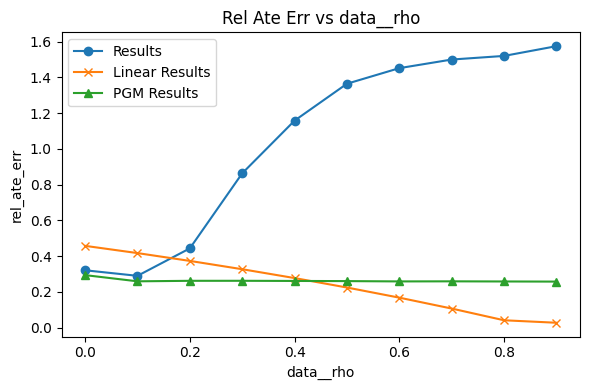

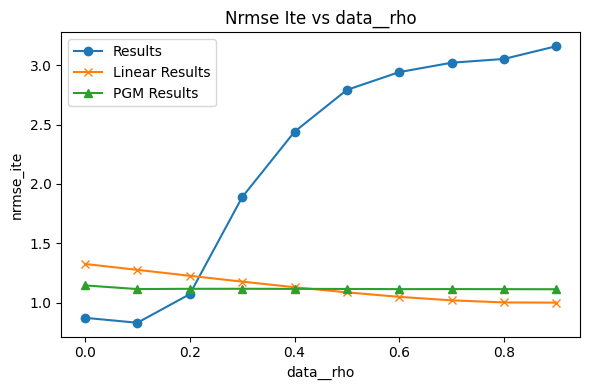

In [31]:
print(corr)
print(corr_baseline)
print(corr_pgm)
plot_three_experiment_results(corr, corr_baseline,corr_pgm, x_param="data__rho")

### E3: increasing decorellation among proxies (through shuffling)

In [15]:
# set up params to sweep
param_grid = {
    "data__shuffle_pct": np.linspace(0.0, 1.0, 11)
}

# run the experiment
res = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

res_baseline = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_non_linear,  
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33259
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33113
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.65956
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.64747
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.40911
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.41476
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.74588
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.74985
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.68083
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.68582
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.53542
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.52035
INFO 	 Tra

    data__shuffle_pct  final_elbo  rel_ate_err  nrmse_ite
0                 0.0   18.188556     0.321387   0.873720
1                 0.1   18.154025     0.645605   1.411286
2                 0.2   18.152578     0.397264   1.015439
3                 0.3   18.391004     0.731200   1.588958
4                 0.4   18.390987     0.666697   1.455071
5                 0.5   18.088074     0.522508   1.238914
6                 0.6   17.866777     0.587809   1.366179
7                 0.7   18.540495     0.622183   1.462561
8                 0.8   18.754407     1.498896   3.025967
9                 0.9   18.773964     1.657841   3.311609
10                1.0   19.028488     1.578221   3.159743
    data__shuffle_pct  final_elbo  rel_ate_err  nrmse_ite
0                 0.0    1.469740     0.457875   1.326758
1                 0.1    1.357008     0.455614   1.323932
2                 0.2    1.411609     0.486988   1.363833
3                 0.3    1.560895     0.719933   1.696941
4             

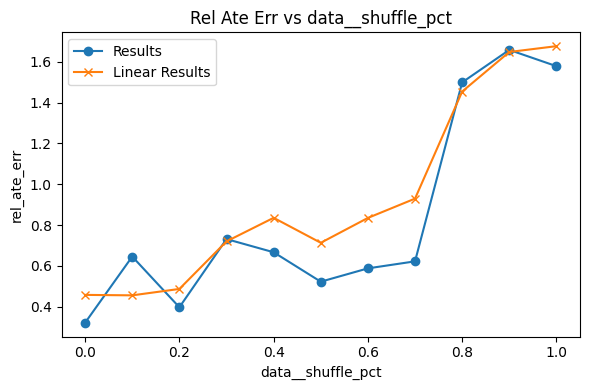

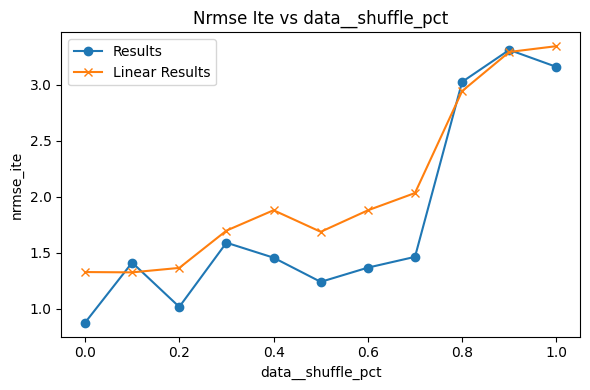

In [16]:
print(res)
print(res_baseline)
plot_two_experiment_results(res, res_baseline, x_param="data__shuffle_pct")

### E4: increasing proxies variance

In [17]:
# set up params to sweep
param_grid = {
    "data__sigma_x": [0.1, 0.5, 1.0, 2.0],
}

# run the experiment
res = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

res_baseline = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_non_linear,  
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.994597
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.993865
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.04124
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.04353
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33259
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33113
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.73563
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.73792


   data__sigma_x  final_elbo  rel_ate_err  nrmse_ite
0            0.1    7.508805     0.013767   0.390996
1            0.5   16.338854     0.032485   0.470946
2            1.0   18.188556     0.321387   0.873720
3            2.0   19.040969     0.721036   1.628641
   data__sigma_x  final_elbo  rel_ate_err  nrmse_ite
0            0.1    1.108638     0.088702   1.014166
1            0.5    1.220003     0.086739   1.013550
2            1.0    1.469740     0.457875   1.326758
3            2.0    1.852248     1.013050   2.172955


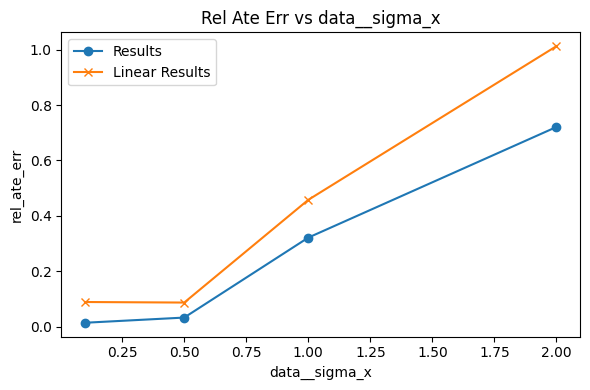

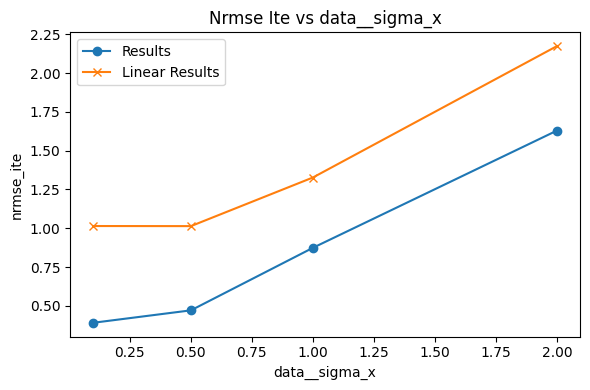

In [18]:
print(res)
print(res_baseline)
plot_two_experiment_results(res, res_baseline, x_param="data__sigma_x")

### E5: increasing outcome variance

In [19]:
# set up params to sweep
param_grid = {
    "data__sigma_y": [0.1, 0.5, 1.0, 2.0],
}

# run the experiment
res = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

res_baseline = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_non_linear,  
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.49997
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.5015
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.42543
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.42442
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33259
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33113
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.14937
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.14572


   data__sigma_y  final_elbo  rel_ate_err  nrmse_ite
0            0.1   16.858517     0.487351   1.146407
1            0.5   17.396847     0.413442   1.016196
2            1.0   18.188556     0.321387   0.873720
3            2.0   19.343216     0.139702   0.698578
   data__sigma_y  final_elbo  rel_ate_err  nrmse_ite
0            0.1    0.414996     0.567744   1.472728
1            0.5    0.672704     0.518912   1.405880
2            1.0    1.469740     0.457875   1.326758
3            2.0    4.646808     0.335798   1.186980


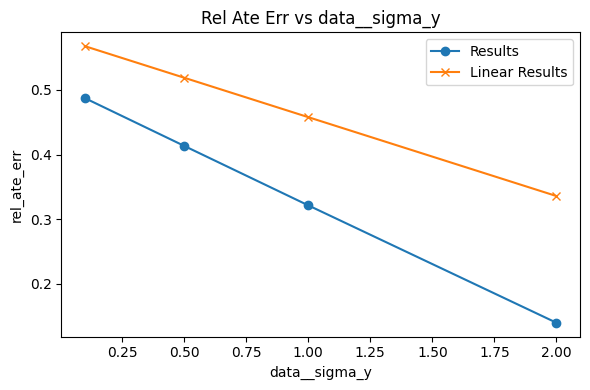

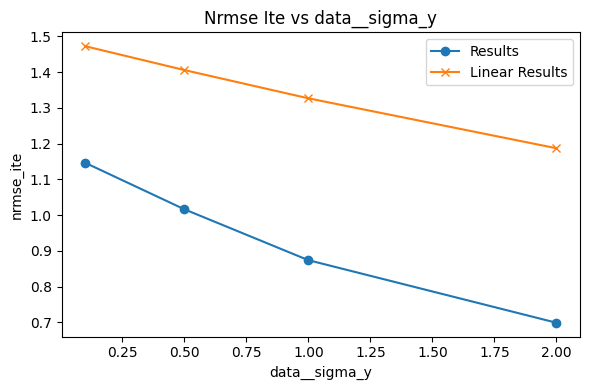

In [20]:
print(res)
print(res_baseline)
plot_two_experiment_results(res, res_baseline, x_param="data__sigma_y")

### E6: increasing the latent dimension (of the CEVAE)

In [ ]:
# set up params to sweep
param_grid = {
    "model__latent_dim": [1, 2, 5, 10, 20],
}

# run the experiment
res = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

# res_baseline = run_experiment(
#     param_grid   = param_grid,
#     data_fn      = synthetic_dataset_non_linear,  
#     model_cls    = LinearModel,
#     metrics_fns  = metrics,                   
#     data_kwargs = data_defaults_non_lin,
#     model_kwargs  = {},      
#     fit_kwargs   = {},
)

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33259
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33113
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.46922
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.47443
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.42704
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.4313
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.46661
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.47564
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.97053
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.96157


TypeError: LinearRegression.__init__() got an unexpected keyword argument 'latent_dim'

   model__latent_dim  final_elbo  rel_ate_err  nrmse_ite
0                  1   18.188556     0.321387   0.873720
1                  2   18.197549     0.456867   1.098722
2                  5   18.185835     0.415036   1.057688
3                 10   18.220372     0.454271   1.101072
4                 20   18.416910     0.953957   1.962789
   data__sigma_y  final_elbo  rel_ate_err  nrmse_ite
0            0.1    0.414996     0.567744   1.472728
1            0.5    0.672704     0.518912   1.405880
2            1.0    1.469740     0.457875   1.326758
3            2.0    4.646808     0.335798   1.186980


KeyError: 'model__latent_dim'

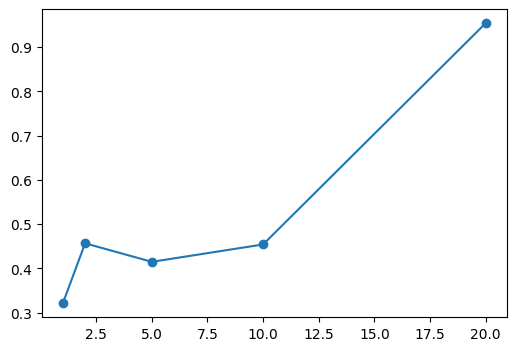

In [23]:
print(res)
print(res_baseline)
plot_two_experiment_results(res, res_baseline, x_param="model__latent_dim")

### E7: prior misspecification

In [24]:
# set up params to sweep
param_grid = {
    "data__prior_type": ["gaussian", "bimodal", "lognormal"],  # type of prior distribution
}

# run the experiment
res = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

res_baseline = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_non_linear,  
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33259
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33113
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.75038
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.75957
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.86175
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.83089


  data__prior_type  final_elbo  rel_ate_err  nrmse_ite
0         gaussian   18.188556     0.321387   0.873720
1          bimodal   16.621934     0.803022   1.081642
2        lognormal   19.722625     0.438384   1.213010
  data__prior_type  final_elbo  rel_ate_err  nrmse_ite
0         gaussian    1.469740     0.457875   1.326758
1          bimodal    1.570434     1.925716   1.922568
2        lognormal   11.552851     0.104440   1.006941


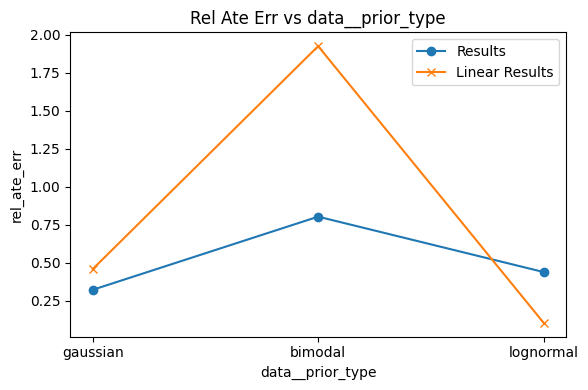

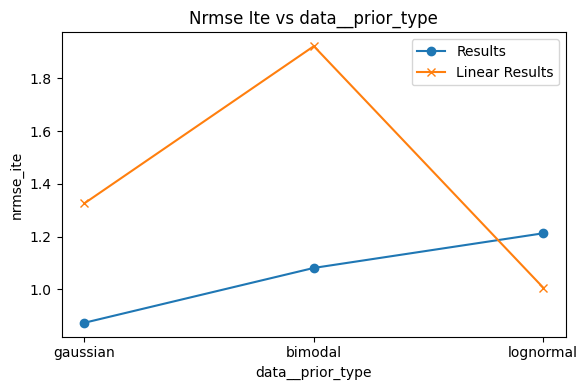

In [25]:
print(res)
print(res_baseline)
plot_two_experiment_results(res, res_baseline, x_param="data__prior_type")

### E8: confounder strenght

In [26]:
# set up params to sweep
param_grid = {
    "data__beta": [0.0, 2.0, 5.0, 10.0]
}

# run the experiment
res = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

res_baseline = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_non_linear,  
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.23518
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.23627
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33259
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33113
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.81031
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.81237
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.99041
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.99389


   data__beta  final_elbo  rel_ate_err  nrmse_ite
0         0.0   18.394512     0.224794   0.761184
1         2.0   18.188556     0.321387   0.873720
2         5.0   18.001156     0.795088   1.642545
3        10.0   17.927501     0.973672   1.986910
   data__beta  final_elbo  rel_ate_err  nrmse_ite
0         0.0    1.544327     0.010332   1.000193
1         2.0    1.469740     0.457875   1.326758
2         5.0    1.399049     0.916750   2.011912
3        10.0    1.364566     1.095495   2.313472


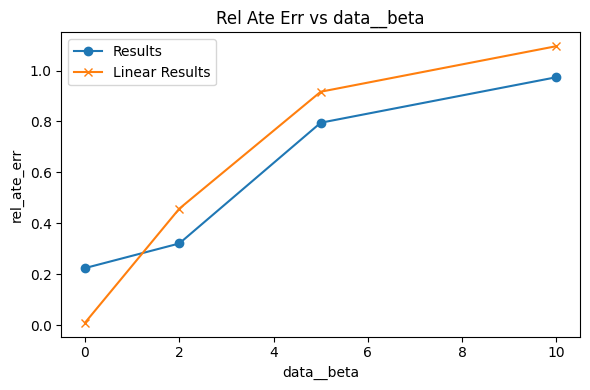

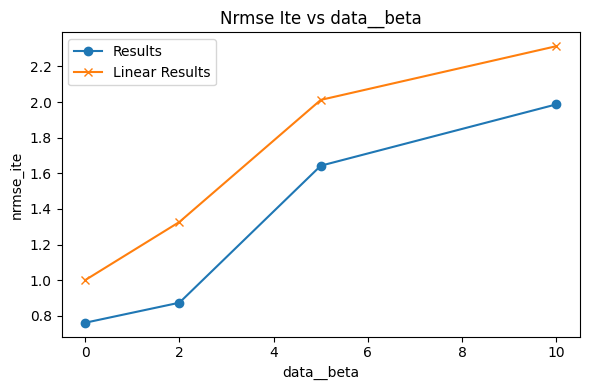

In [28]:
print(res)
print(res_baseline)
plot_two_experiment_results(res, res_baseline, x_param="data__beta")

### E0: $n=1000$, error as function of number of proxies

In [ ]:
n = 1000
proxy_list = list(range(1, 111, 10))

rel_ate_errors = []
nrmse_ites       = []

for num_proxies in proxy_list:
    data = synthetic_dataset_non_linear(
        n=n, num_proxies=num_proxies,
        sigma_x=1.0, sigma_y=1.0,
        shuffle_pct=0.0, prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )
    cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # ATE error (relative)
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(proxy_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("Numero di proxy")
axes[0].set_ylabel("Relative ATE error")
axes[0].set_title("Errore relativo di ATE")

axes[1].plot(proxy_list, nrmse_ites, marker='o', color='green')
axes[1].set_xlabel("Numero di proxy")
axes[1].set_ylabel("Normalized RMSE of ITE")
axes[1].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()

From this experiment we can see two things:
1. for a fixed number of data ($n=1000$) the performance of the model improves as the number of proxies increase. This make sense: the core idea of the use of VAEs to perform causal inference is that we are able to estimate the latent confounder in the big data regime, *i.e.*, in under the assumption that we have enough proxy variable of it. This is  pretty interestin result since nowadays we are in the big data regine. So given enough proxies we can estimate z better and better.
2. the minimum of the loss increases **linearly** when we increase the number of proxies. Does this make sense? Is the Elbow directly proportional (linearly) in the number of proxies (in the paper called $D_x$)? Yes.
The reconstruction term of $x$ 
$$
\mathbb{E}_q[\log(p(x|z))]
$$
where 

$$
\log(p(x|z))=\sum_{j=1}^{D_x}\log(p(x_j|z))
$$

and $p(x_j|z)\sim\mathcal{N}(\mu,\sigma^2)$, hence:

$$
\log(p(x|z))=\sum_{j=1}^{D_x}\frac{1}{2}[\log(2\pi\sigma^2)+\frac{(x_j-\mu_j(z))^2}{\sigma^2}]
$$

and for fixed $\sigma$ it is increasing with $D_x$